In [1]:
import sys
sys.path.append('../src')
from data import get_documents_list, get_cleaned_dataframe_with_topics, get_cleaned_dataframe, get_data_and_labels_lists
from models import classification, get_embedding_model
import pandas as pd
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


loaded spacy language model: de_core_news_sm
loaded spacy language model: en_core_web_sm


For monolingual execution, please change WIKI_LANGUAGES in config.ini file to language code of language you want to use

### Choose Parameters: 
- method = "muse", "fastText", or "Word2Vec"
    -> embedding model 
- text_type = "cleaned_texts", "cleaned_texts_topics", ... (see more in embedding_models.py)
    -> documents the model was trained on and to do classification on
- training_type = "pretrained_aligned" or "from_scratch"
    -> type of training which was used
    
e.g. use method = "muse", text_type='cleaned_texts', training_type = "pretrained_aligned" for pretrained aligned models downloaded from facebookresearch MUSE website

load the preprocessed texts in defined languages into a dataframe

In [2]:
trained_on = "cleaned_sentences"
classify_on = "cleaned_texts_topics"

docs = list()
if classify_on == "cleaned_texts":
    # case for texts
    df = get_cleaned_dataframe()
    df = df[[classify_on, 'label']].copy()
    df = df.rename(columns={classify_on: 'data'})
    docs = get_documents_list('cleaned_texts')
    
elif classify_on == "cleaned_texts_topics":
    df = get_cleaned_dataframe_with_topics(num_topics=5)
    df = df[[classify_on, 'label']].copy()
    df = df.rename(columns={classify_on: 'data'})
    docs = get_documents_list(classify_on)
    
elif classify_on == "cleaned_sentences" or classify_on == "cleaned_paragraphs":
    # case for sentences and paragraphs
    docs, targets = get_data_and_labels_lists(classify_on)
    df = pd.DataFrame(list(zip(docs, targets)),
                   columns =['data', 'label'])
docs

[['Abel',
  'Ehrlich',
  '3.',
  'September',
  '1915',
  'Cranz',
  'Ostpreußen',
  '30.',
  'Oktober',
  '2003',
  'Tel',
  'Aviv',
  'israelisch',
  'Komponist',
  'ehrlich',
  'aufwachsen',
  'deutsch',
  'jüdisch',
  'Familie',
  'fliehen',
  'Abitur',
  'Königsberg',
  '1934',
  'Jugoslawien',
  'studieren',
  'Musikakademie',
  'Zagreb',
  'Komposition',
  'Violin',
  'Vaclav',
  'Huml',
  '1938',
  'emigrieren',
  'Albanien',
  'damalig',
  'Palästina',
  'ab',
  '1939',
  'studieren',
  'Konservatorium',
  'Jerusalem',
  'Emil',
  'Hauser',
  'Tzvi',
  'Rothenberg',
  'Solomon',
  'Rosowski',
  'unterrichten',
  'danach',
  'verschieden',
  'Musikakademi',
  'Jerusalem',
  'Tel',
  'Aviv',
  'darunter',
  '1953',
  '1967',
  'Kibbuzim-Hochschule',
  'Oranim',
  '1972',
  'Professor',
  'damalig',
  'Rubin-Akademie',
  'Tel',
  'Aviv',
  '1991',
  'Bar-Ilan-Universität',
  'lehren',
  'komponieren',
  '3450',
  'Werk',
  'darunter',
  'Oper',
  'Oratorie',
  'sowie',
  'Chor',


## Split data into train and test sets


In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['data'], df['label'] , test_size=0.2)

Decide what types of documents you want to train your embedding model on

## Load Embedding Model

NOTE FOR TRAINING NEW MODEL: 
    
For multilingual fastText Model first train monolingual fastText models (use parameter method="fastText"). 
Then use muse library to align the embeddings: https://github.com/facebookresearch/MUSE
The command could look like this (supervised): 
``` shell
python supervised.py --src_lang en --tgt_lang de --src_emb /Users/jessicahassibi/Bachelor-Thesis/models/classification/FastText/FastText_en_cleaned_texts.vec --tgt_emb /Users/jessicahassibi/Bachelor-Thesis/models/classification/FastText/FastText_de_cleaned_texts.vec --n_refinement 5 --dico_train default --cuda=False
```
or like this (unsupervised):
``` shell
python unsupervised.py --src_lang en --tgt_lang de --src_emb /Users/jessicahassibi/Bachelor-Thesis/models/classification/FastText/FastText_en_cleaned_texts.vec --tgt_emb /Users/jessicahassibi/Bachelor-Thesis/models/classification/FastText/FastText_de_cleaned_texts.vec --n_refinement 5 --cuda=False
```

Place the aligned vectors to /models/classification/FastText/aligned_embeddings and use code in next cell with method="muse" to combine those embeddings and get multilingual word vectors.

In [4]:
method = "muse"
training_type = "pretrained_aligned"

In [5]:
model, word_vectors = get_embedding_model(docs, text_type = "cleaned_texts", training_type = training_type, method = method)

Model:  /home/Bachelor-Thesis/models/classification/FastText/aligned_embeddings/pretrained/wiki.multi.de_en.txt  loaded


In [6]:
#word_vectors.similarity('composer', 'komponist')


## Text Classification on manually trained Embedding model

Highly Imbalanced Dataset!
Ideas:
- Undersampling: reduce majority class to make it equal to minority class
- Oversampling: increase minority class to make it equal to majority class through resampling
- K-fold cross validation

### Choose Parameter: 
- resampling = False, True

In [7]:
resampling = False

### Create features from text for machine learning model.
Steps:
- Turn words in texts into word vectors.

In [8]:
X_train_vect = classification.text2vec(X_train, word_vectors)
X_test_vect = classification.text2vec(X_test, word_vectors)

#- Method 1: averaging word vectors for each text
X_train_vect_avg = classification.average_text_vector(X_train_vect)
X_test_vect_avg = classification.average_text_vector(X_test_vect)

#- Method 2: max word vectors for each text
#- Method 3: min word vectors for each text

### Intuition for Classification reports:
- Recall = how many of this class where found over whole num of elements of this class
- Precision = how many correctly classified among that class
- Accuracy = num of correct predictions/ num of total predictions
- f1-score: harmonic mean between precision and recall
- support: num of occurrence of given class in dataset

- recall macro avg = (recall_class_1 + recall_class_0) / 2
- recall weighted avg = (support_class_0 * recall_class_0 + support_class_1 * recall_class_1) / (support_class_0 + support_class_1)
- scikit learn classification_report average parameter explanation:

-average=micro: compute f1 by considering total true positives, false negatives and false positives (no matter of the prediction for each label in the dataset) (= Accuracy?)

-average=macro: compute f1 for each label, and returns the average without considering the proportion for each label in the dataset. (treats all classes the same)

-average=weighted: compute f1 for each label, and returns the average considering the proportion for each label in the dataset.

-average=samples: compute f1 for each instance, and returns the average. Use it for multilabel classification.


Instantiate and fit a classificator model on top of the vectors

CLASSIFICATION WITH:OVERSAMPLING
1    305
0    305
Name: label, dtype: int64
############################################################################
Processing Random Forest Classification

              precision    recall  f1-score   support

    verfolgt       1.00      0.78      0.88        92
    begnadet       0.00      0.00      0.00         0

    accuracy                           0.78        92
   macro avg       0.50      0.39      0.44        92
weighted avg       1.00      0.78      0.88        92

classes in y_pred: {0, 1} classes in y_test: {0}
############################################################################
############################################################################
Processing Multinomial Naive Bayes Classification

              precision    recall  f1-score   support

    verfolgt       0.61      0.85      0.71        52
    begnadet       0.60      0.30      0.40        40

    accuracy                           0.61        92
   mac

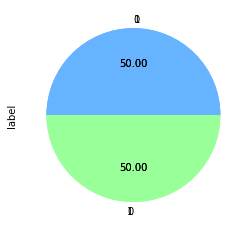

In [13]:
resampling = True
colors = ['#66b3ff','#99ff99']
if not resampling:
    print("CLASSIFICATION WITHOUT SAMPLING:")
    #y_pred = classification.classify_predict(X_train_vect_avg, X_test_vect_avg, y_train, "Random Forest")
    #classification.print_classification_report(y_test, y_pred)

    y_pred = classification.classify_predict(X_train_vect_avg, X_test_vect_avg, y_train, "Multinomial Naive Bayes")
    classification.print_classification_report(y_test, y_pred)

    y_pred = classification.classify_predict(X_train_vect_avg, X_test_vect_avg, y_train, "SVM")
    classification.print_classification_report(y_test, y_pred)
    
    print(y_train.value_counts())
    y_train.value_counts().plot.pie(autopct='%0.2f', colors=colors)
    
else:
    ros = RandomOverSampler(sampling_strategy="not majority")
    rus = RandomUnderSampler(random_state=0, sampling_strategy="majority")
    
    for sampler, method in [(ros, "OVERSAMPLING"),(rus, "UNDERSAMPLING")]:
        print(f"CLASSIFICATION WITH:{method}")
            
        X_train_2d = X_train.values.reshape(-1, 1) # puts each elem of array in own array
        X_res, y_res = sampler.fit_resample(X_train_2d, y_train)
        
        print(y_res.value_counts())
        y_res.value_counts().plot.pie(autopct='%0.2f', colors=colors)
        
        #X_res revert 2_dimensionality
        X_res_1d = X_res.flatten()

        # classification with resampled vectors
        X_res_vect = classification.text2vec(X_res_1d, word_vectors)
        X_res_vect_avg = classification.average_text_vector(X_res_vect)

        y_res_pred = classification.classify_predict(X_res_vect_avg, X_test_vect_avg, y_res, "Random Forest")
        classification.print_classification_report(y_test, y_res_pred)
        y_res_pred = classification.classify_predict(X_res_vect_avg, X_test_vect_avg, y_res, "Multinomial Naive Bayes")
        classification.print_classification_report(y_test, y_res_pred)
        y_res_pred = classification.classify_predict(X_res_vect_avg, X_test_vect_avg, y_res, "SVM")
        classification.print_classification_report(y_test, y_res_pred)